# Model Prototyping

## Imports

In [4]:
!pip install transformers
!pip install textacy
!pip install wandb
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 5.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.5 MB/s eta 0:00:0000:01
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=102031 sha256=9d94629797159d8de84ca880555d8ae02d31e2eb8b7331a26d03d5b28e9911a2
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import train_test_split

# PyTorch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Transformers
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification

# Hyperparameters optimization
import optuna
import wandb
import joblib

In [ ]:
# Google drive files for data
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# GPU used 
!nvidia-smi

Tue Dec  6 17:02:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8     3W /  N/A |    152MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Prototyping using huggingface transformers

In [3]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=True)

# INPUT TWEET IS ALREADY NORMALIZED!
line = "SC has first two presumptive cases of coronavirus , DHEC confirms HTTPURL via @USER :cry:"

input_ids = torch.tensor([tokenizer(line, padding="max_length", max_length=64, truncation=True).input_ids])


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Let's check for how many tokens we'll need

In [58]:
data = pd.read_csv("./train.csv")

In [ ]:
max = 0 
for text in data['text']:
  input_ids = tokenizer(text).input_ids
  max = np.max((max, len(input_ids)))

In [ ]:
print(max)

We can see the maximum number of tokens is 64, to take into account the fact that tweets from the test set may be longer, we'll set the max number of tokens to 90, this will speed the training.

In [ ]:
output = tokenizer.encode(line)
print(output)

In [ ]:
output_dict = tokenizer.encode_plus(line, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
input_ids = output_dict.input_ids
attention_mask = output_dict.attention_mask

In [ ]:
input_ids

In [ ]:
attention_mask

## Data prep

In [ ]:
import html
import re

# define clean function
# add / remove any line if necessary
def clean(text):
    # convert html escapes like &amp; by their plain-text representation
    text = html.unescape(text) 
    
    # subsitute tags like <tab> by spaces in the specified text or remove them
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # subsitute markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # subsitute text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # subsitute standalone sequences of specials, matches &# but NOT #hashtag
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)

     # subsitute standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    #remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)  
    
    #remove old style retweet text "RT"
    text = re.sub(r'RT[\s]+', '', text)        
    text = re.sub(r'DT[\s]+', '', text)   
    
    #remove hashtags
    text = re.sub(r'#', '', text)
    
    return text.strip()

In [ ]:
from textacy import preprocessing
from functools import partial

# create cleaning pipeline
preproc = preprocessing.make_pipeline(
    
    # join words split by a hyphen or line break
    preprocessing.normalize.hyphenated_words,
    
    # subsitute fancy quatation marks with an ASCII equivalent
    preprocessing.normalize.quotation_marks,
    
    # normalize unicode characters in text into canonical forms
    preprocessing.normalize.unicode,
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    preprocessing.remove.accents,

    # remove all email addresses in text 
    partial(preprocessing.replace.emails, repl= ""), # or _EMAIL_
    
    # remove all phone numbers in text 
    partial(preprocessing.replace.phone_numbers, repl=""), # or _PhoneNumber_
    
    # remove all URLs in text 
    partial(preprocessing.replace.urls, repl= ""), # or _URL_
    
    # remove all (Twitter-style) user handles in text 
    partial(preprocessing.replace.user_handles, repl=""), # or _HANDLE_
    
    # Replace all hashtags in text with repl.
    #partial(preprocessing.replace.hashtags, repl="_HASTAG_"),
    
    ### TEST ### Enable it only before generating tokens for word clouds
    partial(preprocessing.replace.numbers, repl=""),
    
    # remove HTML tags from text
    preprocessing.remove.html_tags,

    # remove text within curly {}, square [], and/or round () brackets
    preprocessing.remove.brackets,

    # replace specific set of punctuation marks with whitespace
    partial(preprocessing.remove.punctuation, only=[ ",", ":", ";", "/", " ","(","@"]),
    
    # Replace all currency symbols in text with repl
    preprocessing.replace.currency_symbols,
    
    # replace all emoji and pictographs in text with repl.
    preprocessing.replace.emojis,
    
 )

In [ ]:
# Preprocessing
data['text_c'] = data['text'].apply(clean)
data['text_clean'] = data['text_c'].apply(preproc)
data['text_clean'] = data['text_clean'].str.lower()

In [59]:
input_ids = []
attention_masks = []

tweets = data['text'].to_list()

for tweet in tweets:
  output_dict = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
  input_ids.append(output_dict.input_ids)
  attention_masks.append(output_dict.attention_mask)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels = torch.tensor(data['target'].values)

In [60]:
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(input_ids, attention_masks, labels)

In [7]:

train_size = int(0.85 * len(dataset)) # 85 - 15 % split
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32 # Bigger values will increase the gradient precision, lower values will reduce the memory load

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

In [61]:
# Training on all samples
train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

## Hyperparameters optimization

First, we are going to find the hyperparameters which reduce the val loss the most

In [19]:
# define model inside this function, the archicture can be optimized with optuna
def define_model(trial):

    model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels = 2, output_attentions = False, output_hidden_states = False)  
    
    return model

In [20]:
def train_model_optuna(model, optimizer, scheduler, train_dataloader, trial, device = 'cpu', val_dataloader = None, epochs = 10):
  pbar = tqdm(range(epochs))

  metrics = {
    "epochs" : [],
    "train_losses" : [],
    "val_losses" : [],
    "val_accs" : [],
    "lr" : [],
  }

  for i, epoch in enumerate(pbar):
    model.train()

    total_train_loss = 0
    for i, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      model.zero_grad()

      result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits

      total_train_loss += loss.item()

      loss.backward()

      optimizer.step()

      # Call to scheduler only if it's linear
      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    total_val_acc = 0
    total_val_loss = 0
    
    if val_dataloader is not None:

      model.eval()
      for i, batch in enumerate(val_dataloader):

        input_ids = batch[0].to(device)
        input_masks = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():

          result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

        loss = result.loss
        logits = result.logits.detach().cpu().numpy()
        labels = labels.cpu().numpy()

        preds = np.argmax(logits, axis = 1).flatten()
        labels = labels.flatten()

        val_acc = np.sum(preds == labels) / len(labels)

        total_val_acc += val_acc
        total_val_loss += loss.item()
    
      avg_val_loss = total_val_loss / len(val_dataloader)
      avg_val_acc = total_val_acc / len(val_dataloader)

    metrics['lr'].append(optimizer.param_groups[0]['lr'])

    # Call to scheduler only if it's reduce on plateau
    # scheduler.step(avg_val_loss)

    metrics['epochs'].append(epoch)
    metrics['train_losses'].append(avg_train_loss)

    if val_dataloader is not None :
      metrics['val_losses'].append(avg_val_loss)
      metrics['val_accs'].append(avg_val_acc)
      pbar.set_postfix({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc' : avg_val_acc})

    if trial is not None:
      trial.report(avg_val_loss, epoch)

      # Report metrics to wandb
      wandb.log(data = {
          'train_loss' : metrics['train_losses'][-1],
          'val_loss' : metrics['val_losses'][-1],
          'val_acc' : metrics['val_accs'][-1],
          'lr' : metrics['lr'][-1]
      }, step = epoch)

      if trial.should_prune():
        wandb.run.summary['state'] = "pruned"
        wandb.finish(quiet = True)
        raise optuna.exceptions.TrialPruned()

    if (epoch + 1) % 10 == 0:
      # Saving the fine tunned model
      ckpt = {
          'epoch' : epoch,
          'model_state' : model.state_dict(),
          'optimizer_state' : optimizer.state_dict()
      }

  return model, metrics

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")

def objective(trial):
  
    # Generate the model
    model = define_model(trial).to(device) 

    # Define learning components (to be used in learning function)
    lr = trial.suggest_float("lr", 1e-8, 5e-5)

    optimizer = torch.optim.AdamW(model.parameters(), lr = lr, betas = (0.9, 0.999), eps = 1e-8)

    epochs = trial.suggest_int("epoch", 1, 5)

    total_steps = len(train_dataloader) * epochs

    num_warmup_steps = trial.suggest_int("warmup_steps", 0, int(0.1 * total_steps))

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = total_steps)
    
    # init tracking with wandb
    config = dict(trial.params)
    config['trial.number'] = trial.number
    wandb.init(
        project="twitter_disaster_tweets",
        entity="saulofein",
        config=config,
        group=tag,
        reinit=True        
    )
    
    # Learning
    model, metrics = train_model_optuna(model, optimizer, scheduler, train_dataloader, trial, val_dataloader = val_dataloader, device = device, epochs = epochs)
    
    # Compute the metrics Optuna will try to otpimize (maximize or minimize)
    val_loss = metrics['val_losses'][-1]
    
    # Report the RMSE to wandb
    wandb.run.summary['val_loss'] = val_loss
    wandb.run.summary['state'] = 'completed'
    wandb.finish(quiet = True)
    
    return val_loss

Using device : cuda


In [ ]:
tag = 'bert_1'

study = optuna.create_study(direction = "minimize", study_name = tag)
study.optimize(objective, n_trials = 100)

# Best parameters
print("Best trial :")
best_trial = study.best_trial
print("  Value :", best_trial.value)
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key} : {value}")

# Importance of hyperparameters
importance_dict = optuna.importance.get_param_importances(study = study)
plt.figure(figsize = (20, 15))
sns.barplot(x = list(importance_dict.values()), y = list(importance_dict.keys()))
plt.savefig(os.path.join("..", "hyperparameters_importance_{}.png".format(tag.split('_')[1])))

# Save best parameters dict
joblib.dump(best_trial.params, f"best_params_{tag}.pkl")

Best trial :
  * Value : 0.3834475175374084
  * Params:
    * lr : 3.588461431799714e-05
    * epoch : 1
    * warmup_steps : 8

Relative importance of hyperparameters :
* Number of epochs : 70%
* Learning rate : 30%

## Train model

Using best hyperparameters found, we only need to train it once more and use val data to set the classification threshold

In [62]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels = 2, output_attentions = False, output_hidden_states = False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")

model.to(device)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

Using device : cuda


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [63]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3.588461431799714e-05, betas = (0.9, 0.999), eps = 1e-8)

In [64]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import get_linear_schedule_with_warmup

def train_model(model, optimizer, scheduler, train_dataloader, val_dataloader = None, epochs = 10):
  pbar = tqdm(range(epochs))

  metrics = {
    "epochs" : [],
    "train_losses" : [],
    "val_losses" : [],
    "val_accs" : [],
    "lr" : [],
  }

  for i, epoch in enumerate(pbar):
    model.train()

    total_train_loss = 0
    for i, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      model.zero_grad()

      result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits

      total_train_loss += loss.item()

      loss.backward()

      optimizer.step()

      # Call to scheduler only if it's linear
      scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    total_val_acc = 0
    total_val_loss = 0
    
    if val_dataloader is not None:

      model.eval()
      for i, batch in enumerate(val_dataloader):

        input_ids = batch[0].to(device)
        input_masks = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():

          result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

        loss = result.loss
        logits = result.logits.detach().cpu().numpy()
        labels = labels.cpu().numpy()

        preds = np.argmax(logits, axis = 1).flatten()
        labels = labels.flatten()

        val_acc = np.sum(preds == labels) / len(labels)

        total_val_acc += val_acc
        total_val_loss += loss.item()
    
      avg_val_loss = total_val_loss / len(val_dataloader)
      avg_val_acc = total_val_acc / len(val_dataloader)

    metrics['lr'].append(optimizer.param_groups[0]['lr'])

    # Call to scheduler only if it's reduce on plateau
    # scheduler.step(avg_val_loss)

    metrics['epochs'].append(epoch)
    metrics['train_losses'].append(avg_train_loss)

    if val_dataloader is not None :
      metrics['val_losses'].append(avg_val_loss)
      metrics['val_accs'].append(avg_val_acc)
      pbar.set_postfix({'train_loss': avg_train_loss, 'val_loss': avg_val_loss, 'val_acc' : avg_val_acc})

    if (epoch + 1) % 10 == 0:
      # Saving the fine tunned model
      ckpt = {
          'epoch' : epoch,
          'model_state' : model.state_dict(),
          'optimizer_state' : optimizer.state_dict()
      }
      torch.save(ckpt, "weights_bertweet_intermediate.pt")

  # Saving the fine tunned model
  ckpt = {
          'epoch' : epoch,
          'model_state' : model.state_dict(),
          'optimizer_state' : optimizer.state_dict()
      }
  torch.save(ckpt, "weights_bertweet_final.pt")

  return model, metrics

In [65]:
epochs = 1

total_steps = len(train_dataloader) * epochs

# scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience = 5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 8, num_training_steps = total_steps)

model, metrics = train_model(model, optimizer, scheduler, train_dataloader, epochs = epochs)

100%|██████████| 1/1 [08:10<00:00, 490.53s/it]


Text(0.5, 1.0, 'Learning rate')

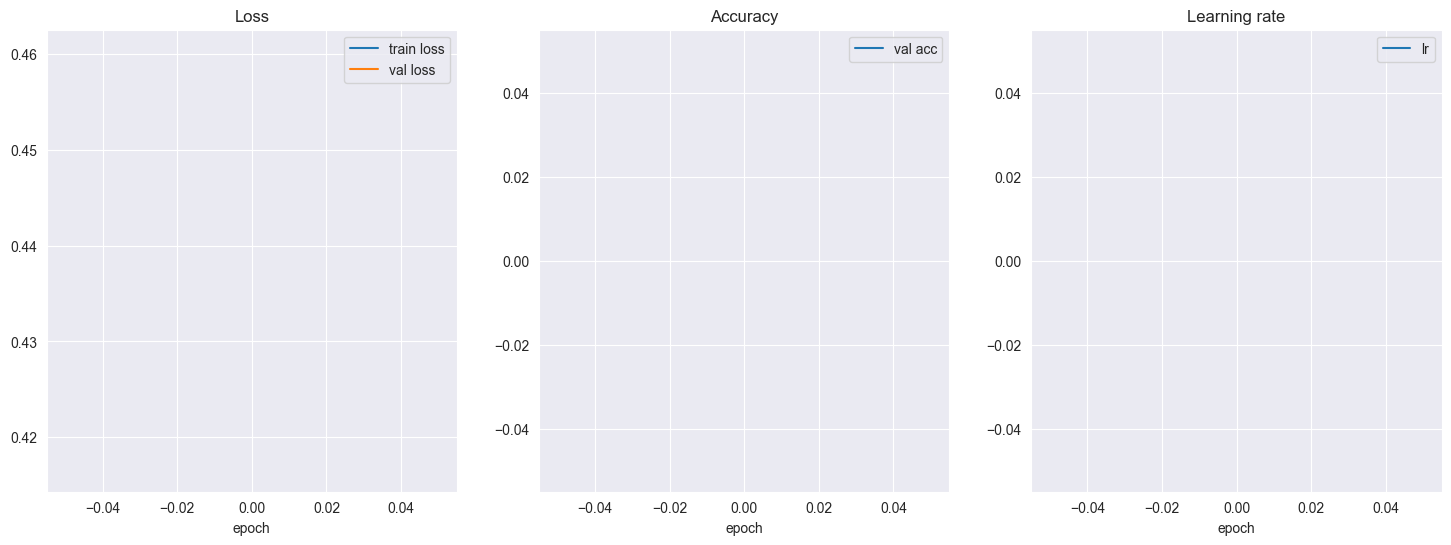

In [66]:
# Visualization of the metrics
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)

plt.plot(metrics['train_losses'], label='train loss')
plt.plot(metrics['val_losses'], label='val loss')
plt.xlabel("epoch")
plt.legend()
plt.title('Loss')

plt.subplot(1, 3, 2)
plt.plot(metrics['val_accs'], label='val acc')
plt.xlabel("epoch")
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(metrics['lr'], label='lr')
plt.xlabel("epoch")
plt.legend()
plt.title('Learning rate')

In [67]:
def make_confusion_heatmap(
        cf,
        group_names=None,
        categories="auto",
        count=True,
        percent=True,
        cbar=True,
        xyticks=True,
        xyplotlabels=True,
        sum_stats=True,
        figsize=None,
        cmap="Blues",
        title=None,
):
    """
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    """

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ["" for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score
            )
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get("figure.figsize")

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(
        cf,
        annot=box_labels,
        fmt="",
        cmap=cmap,
        cbar=cbar,
        xticklabels=categories,
        yticklabels=categories,
    )

    if xyplotlabels:
        plt.ylabel("True label")
        plt.xlabel("Predicted label" + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
      plt.title(title)

In [28]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [68]:
from sklearn.metrics import confusion_matrix

def get_preds(dataloader, model, threshold = 0.5, device = 'cpu'):
  
  all_labels = torch.tensor([])
  all_preds = torch.tensor([])

  model.eval()
  for i, batch in enumerate(dataloader):

      input_ids = batch[0].to(device)
      input_masks = batch[1].to(device)
      labels = batch[2].to(device)

      with torch.no_grad():
        result = model(input_ids, token_type_ids = None, attention_mask = input_masks, labels = labels, return_dict = True)

      loss = result.loss
      logits = result.logits.detach().cpu()
      labels = labels.cpu()

      preds = torch.tensor((logits[:, 1].cpu() >= threshold), dtype=torch.int)
      labels = labels.flatten()

      all_labels = torch.cat((all_labels, labels), dim=0)
      all_preds = torch.cat((all_preds, preds), dim=0)

  return all_labels, all_preds

In [102]:
all_labels, all_preds = get_preds(val_dataloader, model, 0.4368, device)
cm = confusion_matrix(all_labels, all_preds)

C:\Users\romai\AppData\Local\Temp\ipykernel_10032\2241719297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor((logits[:, 1].cpu() >= threshold), dtype=torch.int)


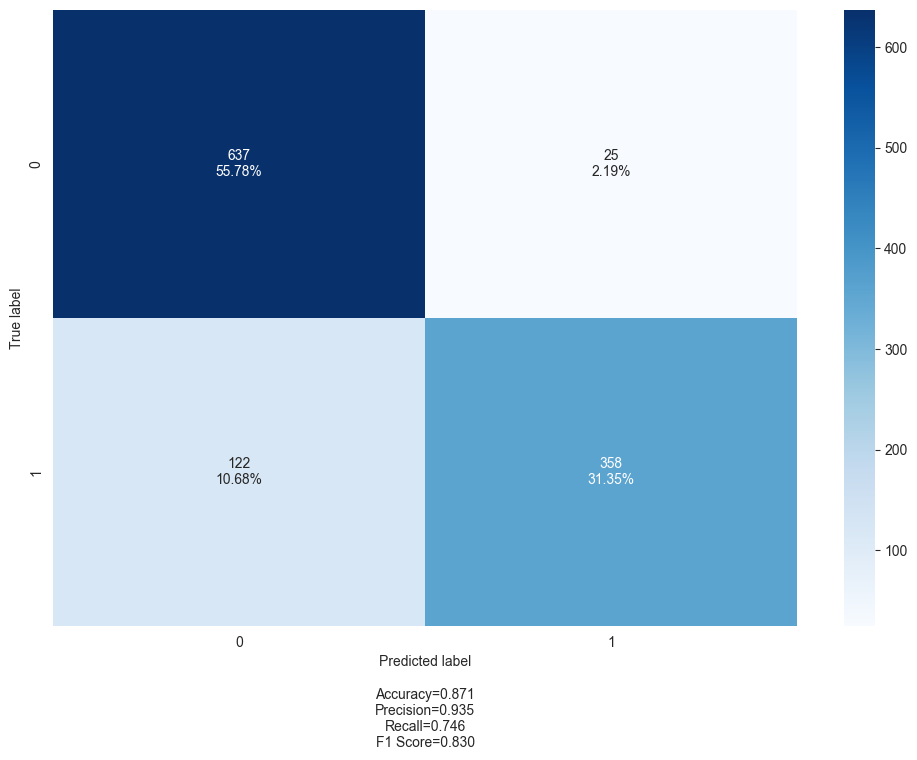

In [103]:
make_confusion_heatmap(cm, figsize=(12,8))

In [104]:
from sklearn.metrics import roc_auc_score
roc_auc_score(all_labels, all_preds)

0.8540344914400806

Now let's find the best classification threshold based on accuracy and see how it compares to default one (50%)

In [71]:
from sklearn.metrics import accuracy_score

thresholds = np.linspace(0.1, 0.9, 20)

accuracies = []
for threshold in thresholds:
    all_labels, all_preds = get_preds(val_dataloader, model, threshold, device)
    accuracies.append(accuracy_score(all_labels, all_preds))

C:\Users\romai\AppData\Local\Temp\ipykernel_10032\2241719297.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor((logits[:, 1].cpu() >= threshold), dtype=torch.int)


KeyboardInterrupt: 

In [40]:
print(accuracies)

[0.8467600700525394, 0.8485113835376532, 0.8528896672504378, 0.850262697022767, 0.852014010507881, 0.8528896672504378, 0.852014010507881, 0.8528896672504378, 0.8537653239929948, 0.852014010507881, 0.851138353765324, 0.852014010507881, 0.8493870402802102, 0.8476357267950964, 0.8476357267950964, 0.8458844133099825, 0.8441330998248686, 0.8458844133099825, 0.8423817863397548, 0.839754816112084]


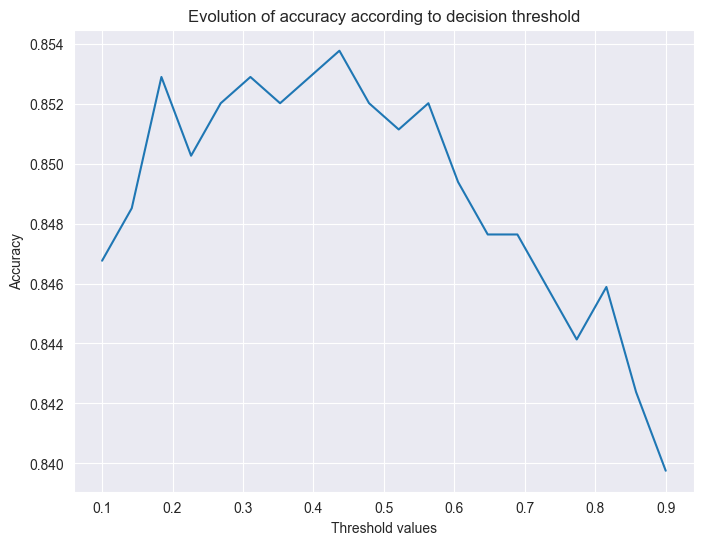

In [55]:
f = plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies)
plt.title("Evolution of accuracy according to decision threshold")
plt.xlabel("Threshold values")
plt.ylabel("Accuracy")
plt.savefig("accuracy_threhsolds.png")

In [43]:
max_accuracy = np.max(accuracies)
best_treshold = thresholds[np.argmax(accuracies)]
print(f"Max accuracy : {max_accuracy}")
print(f"Best threshold : {best_treshold}")

Max accuracy : 0.8537653239929948
Best threshold : 0.4368421052631579


Max accuracy : 0.8537
Best threshold : 0.4368

## Make a submission

In [72]:
test_data = pd.read_csv("test.csv")
print(f"Size of test set : {len(test_data)}")

In [73]:
input_ids = []
attention_masks = []

tweets = test_data['text'].to_list()

for tweet in tweets:
  output_dict = tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=90, padding='max_length', return_attention_mask=True, return_tensors='pt')
  input_ids.append(output_dict.input_ids)
  attention_masks.append(output_dict.attention_mask)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [74]:
from torch.utils.data import TensorDataset, random_split, DataLoader

dataset = TensorDataset(input_ids, attention_masks)

test_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

In [96]:
all_preds = torch.tensor([])

model.eval()
for i, batch in enumerate(test_dataloader):

  input_ids = batch[0].to(device)
  input_masks = batch[1].to(device)

  with torch.no_grad():
    result = model(input_ids, token_type_ids = None, attention_mask = input_masks, return_dict = True)

    logits = result.logits.detach().cpu()

    preds = torch.tensor((logits[:, 1] >= 0.5), dtype = torch.int32)

    all_preds = torch.cat((all_preds, preds), dim = 0)

C:\Users\romai\AppData\Local\Temp\ipykernel_10032\3590119552.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor((logits[:, 1] >= 0.5), dtype=int)


In [97]:
ids = test_data['id']
preds = pd.DataFrame(all_preds.numpy().astype(np.int32), columns = ['target'])
res = pd.merge(ids, preds, left_index = True, right_index = True)

In [98]:
res.to_csv("res_optih.csv", sep = ",", index = False)

To submit the res file :

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f res.csv

# Results

## Metrics

\begin{table}[]
\begin{tabular}{|l|l|l|l|l|}
\hline
Model                     & Accuracy_on_test_set & Accuracy_on_train_set & F1_on_train_set & ROCAUC_on_train_set \\ \hline
Opti\_h, opti\_t (t\_acc) & 0.84186              & 0.871                 & 0.83            & 0.854               \\ \hline
Opti\_h                   & 0.84002              & 0.870                 & 0.827           & 0.852               \\ \hline
No\_opti                  & 0.844                & 0.890                 & ?               & ?                   \\ \hline
\end{tabular}
\end{table}

## Analysis of tweets wrongly classified

In [ ]:
all_preds, all_labels = get_preds(train_dataloader, model, device)

In [ ]:
wrong_preds = (all_preds != all_labels)

In [ ]:
wrong_preds = np.array(wrong_preds)

In [ ]:
wrong_tweets = data[wrong_preds]

In [ ]:
wrong_tweets['pred'] = (wrong_tweets['target'] + 1) % 2

In [ ]:
wrong_tweets

## Possible improvements

* To improve the model performance we could set a threshold that maximises the val accuracy rather than just using argmax, which is equivalent to threshold 50%
* Create an ensemble learning architecture
* Rather than optimizing the threshold for accuracy, we could do it for f1 score, recall or precision and see what we get
* Should try to optimize hyperparameters based on accuracy